In [43]:
!pip install "gym>=0.21.0"
!pip install tf-agents[reverb]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import array_spec

In [45]:
class BlackJackEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state], dtype=np.int32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Make sure episodes don't go on forever.
    if action == 1:
      self._episode_ended = True
    elif action == 0:
      new_card = np.random.randint(1, 11)
      self._state += new_card
    else:
      raise ValueError('`action` should be 0 or 1.')

    if self._episode_ended or self._state >= 21:
      reward = self._state - 21 if self._state <= 21 else -21
      return ts.termination(np.array([self._state], dtype=np.int32), reward)
    else:
      return ts.transition(
          np.array([self._state], dtype=np.int32), reward=0.0, discount=1.0)

In [46]:
# validate environment
environment = BlackJackEnv()
utils.validate_py_environment(environment, episodes=3)

In [47]:
# run 1 complete episode + 1 time step to confirm episode ended
get_new_card_action = np.array(0, dtype=np.int32)
end_round_action = np.array(1, dtype=np.int32)

environment = BlackJackEnv()
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward

for _ in range(3):
  time_step = environment.step(get_new_card_action)
  print(time_step)
  cumulative_reward += time_step.reward

time_step = environment.step(end_round_action)
print(time_step)
cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward)

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0], dtype=int32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([8], dtype=int32),
 'reward': array(0., dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([9], dtype=int32),
 'reward': array(0., dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([17], dtype=int32),
 'reward': array(0., dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(0., dtype=float32),
 'observation': array([17], dtype=int32),
 'reward': array(-4., dtype=float32),
 'step_type': array(2, dtype=int32)})
Final Reward =  -4.0


In [48]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 2s (154 kB/s)
Reading package lis

In [49]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [50]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"} 

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [51]:
from tf_agents.environments import TimeLimit
env = BlackJackEnv()
env = TimeLimit(env,52)

In [52]:
type(env)

tf_agents.environments.wrappers.TimeLimit

In [53]:
print(env.time_step_spec().observation)

BoundedArraySpec(shape=(1,), dtype=dtype('int32'), name='observation', minimum=0, maximum=2147483647)


In [54]:
train_py_env = BlackJackEnv()
eval_py_env = BlackJackEnv()
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [55]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [57]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [58]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [59]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [60]:
compute_avg_return(eval_env, random_policy, 5)

-19.6

In [61]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [62]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0., dtype=float32),
  'observation': array([6], dtype=int32),
  'reward': array(-15., dtype=float32),
  'step_type': array(2, dtype=int32)}), ())

In [63]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

In [64]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 124.63419342041016
step = 400: loss = 8.649969100952148
step = 600: loss = 5.632431507110596
step = 800: loss = 2.3196306228637695
step = 1000: loss = 4.213759899139404
step = 1000: Average Return = -6.199999809265137
step = 1200: loss = 0.7166315317153931
step = 1400: loss = 1.798963189125061
step = 1600: loss = 7.42094087600708
step = 1800: loss = 9.940373420715332
step = 2000: loss = 7.550225734710693
step = 2000: Average Return = -7.400000095367432
step = 2200: loss = 10.072859764099121
step = 2400: loss = 7.874968528747559
step = 2600: loss = 4.7794365882873535
step = 2800: loss = 1.7766411304473877
step = 3000: loss = 1.4950364828109741
step = 3000: Average Return = -5.699999809265137
step = 3200: loss = 3.3352508544921875
step = 3400: loss = 5.691623210906982
step = 3600: loss = 4.452846527099609
step = 3800: loss = 6.129815101623535
step = 4000: loss = 16.506084442138672
step = 4000: Average Return = -6.5
step = 4200: loss = 2.3423337936401367
step = 4400: lo

Text(0.5, 0, 'Iterations')

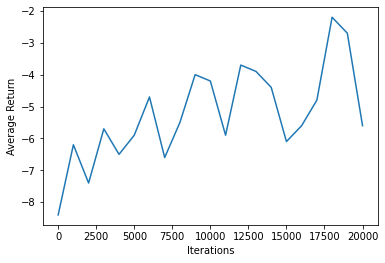

In [65]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')